### Imports

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.kernel_approximation import Nystroem
import matplotlib.pyplot as plt 
import numpy as np

### NTK

#### NTK Class

In [19]:
class NTK(Kernel):
    def __init__(
        self, 
        depth, 
        c=2.0):
        self.depth = depth
        self.c = c

    # Need's rewrite -> 2007.01580 uses x,z in R^d not whole matricies
    # sigma_0(X,Z) = X @ Z.T -> usually vector x vector = scaler
    #                        -> but with n x m 
    def __call__(self, X, Z=None, eval_gradient=False):
        aug = False
        X_shape = -1
        Z_shape = -1

        if Z is None:
            Z = X
        else:
            X_shape = X.shape[0]
            Z_shape = Z.shape[0]
            A = np.concatenate((X, Z), axis=0)
            X = A 
            Z = A
            aug = True
            
        Σ = X @ Z.T
        Σ_dot = np.zeros_like(Σ)
        Θ = np.zeros((self.depth, X.shape[0], Z.shape[0]))
        Θ[0] = Σ

        D = np.sqrt((X @ X.T) * (Z @ Z.T))
        
        for dep in range(1, self.depth):
            diag = np.diag(Σ)
            denominator = np.sqrt(np.outer(diag, diag))
            λ = np.clip(Σ / denominator, a_min = - 1, a_max = 1)
            Σ = (self.c/(2*np.pi)) * λ * (np.pi - np.arccos(λ) + np.sqrt(1 - λ**2)) * denominator
            Σ_dot = (self.c/(2*np.pi)) * (np.pi - np.arccos(λ))
            Θ[dep] = Θ[dep-1] * Σ_dot + Σ

        if eval_gradient:
            return Θ[self.depth-1], np.empty((X.shape[0], X.shape[0], 0))
        else:
            if aug:
                return Θ[self.depth-1, 0:X_shape, X_shape:(X_shape + Z_shape)]
            else:
                return Θ[self.depth-1]
        
        # return Θ

    def diag(self, X):
        return np.einsum("ij,ij->i", X, X)

    def is_stationary(self):
        """Returns whether the kernel is stationary."""
        return False

    def __repr__(self):
        return "{0}(depth={1:d}, c={2:.3f})".format(
                self.__class__.__name__, self.depth, self.c)

#### NTK Function

In [ ]:
"""
Neural Tangent Kernel Precompute
https://github.com/LeoYu/neural-tangent-kernel-UCI/
"""
def ntk_value(X, d_max, fix_dep): 
    K = np.zeros((d_max, X.shape[0], X.shape[0]))
    Σ = np.matmul(X, X.T)
    Σ_dot = np.zeros_like(Σ)
    for dep in range(d_max):
        if fix_dep <= dep:
            Σ_dot += Σ
        K[dep] = Σ_dot
        L = np.diag(Σ)
        P = np.clip(np.sqrt(np.outer(L, L)), a_min = 1e-9, a_max = None)
        λ = np.clip(Σ / P, a_min = -1, a_max = 1)
        Σ = (λ * (math.pi - np.arccos(λ)) + np.sqrt(1.0 - λ * λ)) * P / 2.0 / math.pi
        Σ_dot = Σ_dot * (math.pi - np.arccos(λ)) / 2.0 / math.pi
    return K[d_max - 1]

### Gaussian Process

In [3]:
z = np.linspace(-2, 2, 100)
x = (z**2 + 1) * np.sin(np.linspace(-4*np.pi, 4*np.pi, 100))
y = (z**2 + 1) * np.cos(np.linspace(-4*np.pi, 4*np.pi, 100))

X = np.stack((x, y), axis=1)
z = z.reshape((-1, 1))

# X = X.reshape((-1, 1))
# y = y.reshape((-1, 1))

# training_indices = rng.choice(np.arange(y.size), size=10, replace=False)
# x_train, y_train = X[training_indices], y[training_indices]
# y_train_noisy = y_train + rng.normal(loc=0.0, scale=0.75, size=y_train.shape)

In [5]:
X_train, X_test, z_train, z_test = train_test_split(
    X, z, test_size=0.7, random_state=624562)

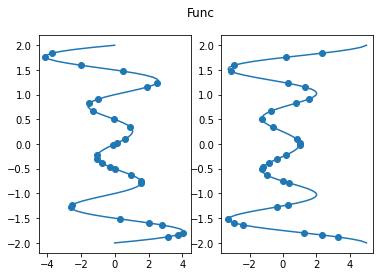

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.plot(X[:,0], z)
ax1.scatter(X_train[:,0], z_train)
ax2.plot(X[:,1], z)
ax2.scatter(X_train[:,1], z_train)
_ = fig.suptitle("Func")

In [13]:
X_train_norm = normalize(X_train)
z_train_norm = normalize(z_train)

X_norm = normalize(X)
z_norm = normalize(z)

In [72]:
# kernel = 1 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=0.5)
# kernel = ConstantKernel() * RBF(1, length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(0.1, (1e-9, 1e5))
neural_tangent_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
    NTK(depth=3, c=2.0) #+ 
    #WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)
gp_ntk = GPR(kernel=neural_tangent_kernel, n_restarts_optimizer=9)
gp_ntk.fit(X_train_norm, z_train_norm)

laplace_kernel = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
    Matern(nu=1/2) #+ 
    #WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-9, 1e5))
)
gp_lpk = GPR(kernel=laplace_kernel, n_restarts_optimizer=9)
gp_lpk.fit(X_train_norm, z_train_norm)

gp_ntk.kernel_, gp_lpk.kernel_

(0.000158**2 * NTK(depth=3, c=2.000),
 1**2 * Matern(length_scale=0.0214, nu=0.5))

In [73]:
mean_ntk, std_ntk = gp_ntk.predict(X_norm, return_std=True)
mean_lpk, std_lpk = gp_lpk.predict(X_norm, return_std=True)

/home/rona1das/Tools/anaconda3/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:428: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


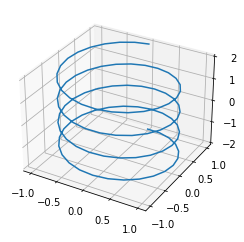

In [59]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(X_norm[:,0], X_norm[:,1], z.ravel())

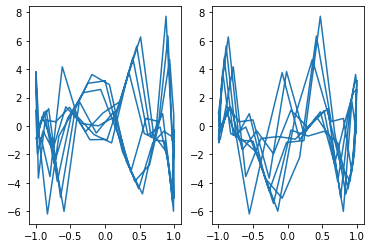

In [74]:
# ax = plt.figure().add_subplot(projection='3d')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.plot(X_norm[:,0], mean_ntk.ravel())
ax2.plot(X_norm[:,1], mean_ntk.ravel())

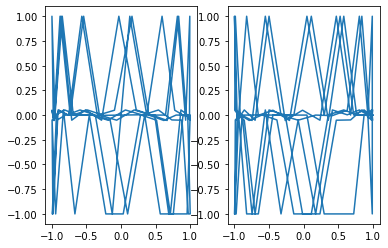

In [75]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.plot(X_norm[:,0], mean_lpk.ravel())
ax2.plot(X_norm[:,1], mean_lpk.ravel())

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.plot(X[:,0], z)
ax1.scatter(X_train[:,0], z_train)
ax2.plot(X[:,1], z)
ax2.scatter(X_train[:,1], z_train)
_ = fig.suptitle("Func")

In [ ]:
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(x=x_train.ravel(), y=y_train.ravel())
plt.plot(X, mean_pred, label="Mean prediction")
plt.fill_between(
    X.ravel(), 
    mean_pred.ravel() - 1.96*std_pred.ravel(), 
    mean_pred.ravel() + 1.96*std_pred.ravel(),
    alpha=0.5)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset")

In [ ]:
laplace_kernel = Matern(
    length_scale=1.0,
    length_scale_bounds=(1e-5, 1e5),
    nu=1/2
    )

